                Валерия Бакланова

# Машинное обучение, ФКН ВШЭ

## Практическое задание 8. Метод опорных векторов и аппроксимация ядер

### Общая информация
Дата выдачи: 1.10.2021

Мягкий дедлайн: 17.10.2021 23:59 МСК

Жесткий дедлайн: 24.10.2021 23:59 МСК (1 неделя -- минус балл)

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимальная оценка за работу (без учёта бонусов) — 10 баллов.

Сдавать задание после указанного жёсткого срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Загрузите решение в свой репозиторий на github и поделитесь [ссылкой на решение в форме](https://forms.gle/ZzCaqRj6bmfpSpyL7). Не забудьте дать доступ к Вашему репозиторию, что у преподавателей была возмоожность проверить работу.

### О задании

На занятиях мы подробно обсуждали метод опорных векторов (SVM). В базовой версии в нём нет чего-то особенного — мы всего лишь используем специальную функцию потерь, которая не требует устремлять отступы к бесконечности; ей достаточно, чтобы отступы были не меньше +1. Затем мы узнали, что SVM можно переписать в двойственном виде, который, позволяет заменить скалярные произведения объектов на ядра. Это будет соответствовать построению модели в новом пространстве более высокой размерности, координаты которого представляют собой нелинейные модификации исходных признаков.

Ядровой SVM, к сожалению, довольно затратен по памяти (нужно хранить матрицу Грама размера $d \times d$) и по времени (нужно решать задачу условной оптимизации с квадратичной функцией, а это не очень быстро). Мы обсуждали, что есть способы посчитать новые признаки $\tilde \varphi(x)$ на основе исходных так, что скалярные произведения этих новых $\langle \tilde \varphi(x), \tilde \varphi(z) \rangle$ приближают ядро $K(x, z)$.

Мы будем исследовать аппроксимации методом Random Fourier Features (RFF, также в литературе встречается название Random Kitchen Sinks) для гауссовых ядер. Будем использовать формулы, которые немного отличаются от того, что было на лекциях (мы добавим сдвиги внутрь тригонометрических функций и будем использовать только косинусы, потому что с нужным сдвигом косинус превратится в синус):
$$\tilde \varphi(x) = (
\cos (w_1^T x + b_1),
\dots,
\cos (w_n^T x + b_n)
),$$
где $w_j \sim \mathcal{N}(0, 1/\sigma^2)$, $b_j \sim U[-\pi, \pi]$.

На новых признаках $\tilde \varphi(x)$ мы будем строить любую линейную модель.

Можно считать, что это некоторая новая парадигма построения сложных моделей. Можно направленно искать сложные нелинейные закономерности в данных с помощью градиентного бустинга или нейронных сетей, а можно просто нагенерировать большое количество случайных нелинейных признаков и надеяться, что быстрая и простая модель (то есть линейная) сможет показать на них хорошее качество. В этом задании мы изучим, насколько работоспособна такая идея.

### Алгоритм

Вам потребуется реализовать следующий алгоритм:
1. Понизить размерность выборки до new_dim с помощью метода главных компонент.
2. Для полученной выборки оценить гиперпараметр $\sigma^2$ с помощью эвристики (рекомендуем считать медиану не по всем парам объектов, а по случайному подмножеству из где-то миллиона пар объектов): $$\sigma^2 = \text{median}_{i, j = 1, \dots, \ell, i \neq j} \left\{\sum_{k = 1}^{d} (x_{ik} - x_{jk})^2 \right\}$$
3. Сгенерировать n_features наборов весов $w_j$ и сдвигов $b_j$.
4. Сформировать n_features новых признаков по формулам, приведённым выше.
5. Обучить линейную модель (логистическую регрессию или SVM) на новых признаках.
6. Повторить преобразования (PCA, формирование новых признаков) к тестовой выборке и применить модель.

Тестировать алгоритм мы будем на данных Fashion MNIST. Ниже код для их загрузки и подготовки.

In [5]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold


import matplotlib.pyplot as plt

import time

import keras
from keras.datasets import fashion_mnist



In [6]:
import keras
from keras.datasets import fashion_mnist
(x_train_pics, y_train), (x_test_pics, y_test) = fashion_mnist.load_data()
x_train = x_train_pics.reshape(x_train_pics.shape[0], -1)
x_test = x_test_pics.reshape(x_test_pics.shape[0], -1)

__Задание 1. (5 баллов)__

Реализуйте алгоритм, описанный выше. Можете воспользоваться шаблоном класса ниже или написать свой интерфейс.

Ваша реализация должна поддерживать следующие опции:
1. Возможность задавать значения гиперпараметров new_dim (по умолчанию 50) и n_features (по умолчанию 1000).
2. Возможность включать или выключать предварительное понижение размерности с помощью метода главных компонент.
3. Возможность выбирать тип линейной модели (логистическая регрессия или SVM с линейным ядром).

Протестируйте на данных Fashion MNIST, сформированных кодом выше. Если на тесте у вас получилась доля верных ответов не ниже 0.84 с гиперпараметрами по умолчанию, то вы всё сделали правильно.

In [7]:
np.random.seed(100)

In [8]:
x_test.shape

(10000, 784)

In [9]:
from sklearn.base import BaseEstimator, TransformerMixin


class RFFPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg'):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        
        Feel free to edit this template for your preferences.    
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier = classifier
        
    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪

        # 1-st step. PCA 
        
        if self.use_PCA==True:
            self.sc = StandardScaler()
            X_std = self.sc.fit_transform(X)
            self.pca = PCA(n_components=self.new_dim)
            X_pca = self.pca.fit_transform(X_std)
            self.X_pca = X_pca
        else:
            self.X_pca = X

        # 2-nd step. sigma

        var_hat_all = np.zeros(10**6)
        for par in range(10**6):
            i, j = np.random.randint(low=0, high=self.X_pca.shape[0], size=2)

            while i-j == 0:
              i, j = np.random.randint(low=0, high=self.X_pca.shape[0], size=2)
  

            res = np.sum((self.X_pca[i,:] - self.X_pca[j,:]) ** 2)
            var_hat_all[par] = res
            
        est_med = np.median(var_hat_all)
        self.est_med = est_med


        # 3-d step. generating b, W
        
        b = np.random.uniform(-np.pi, np.pi, size=self.n_features)
        
        W = np.zeros((self.X_pca.shape[1], self.n_features))
        W[:,:] = np.random.normal(loc=0, scale=np.sqrt(1/self.est_med), size=(self.X_pca.shape[1], self.n_features))

        self.W = W
        self.b = b

        # 4-th step. cos 
        
        #new_x = np.zeros((self.X_pca.shape[0], self.n_features))

        # for i in range(self.n_features):
        #     w_i = self.W[:, i].reshape(self.new_dim, 1)
        #     new_x[:, i] = np.cos(w_i.T.dot(self.X_pca.T) + self.b[i])

        # for i in range(self.X_pca.shape[0]):
        #     cos_i = np.cos(X_pca[i,:].dot(self.W) + self.b)
        #     new_x[i, :] = cos_i

        new_x = np.cos(self.X_pca.dot(self.W) + self.b)


        self.sc_new = StandardScaler()
        new_x = self.sc_new.fit_transform(new_x)

        self.new_x = new_x


        # 5-th step. Fitting logreg/SVM

        if self.classifier == 'logreg':
            clf = LogisticRegression(n_jobs=-1)
            clf.fit(self.new_x, y)
            self.clf = clf
        
        if self.classifier == 'SVM':
            clf = SVC(kernel='linear')
            clf.fit(self.new_x, y)
            self.clf = clf
        
        return self.clf


    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        if self.use_PCA==True:
            X_test_std = self.sc.transform(X)
            X_test_pca = self.pca.transform(X_test_std)
            self.X_test_pca = X_test_pca
        else:
            self.X_test_pca = X

        
        new_x_test = np.cos(self.X_test_pca.dot(self.W) + self.b)


        new_x_test = self.sc_new.transform(new_x_test)
        pred_proba = self.clf.predict_proba(new_x_test)
        
        return pred_proba

    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        
        if self.use_PCA==True:
            X_test_std = self.sc.transform(X)
            X_test_pca = self.pca.transform(X_test_std)
            self.X_test_pca = X_test_pca
        else:
            self.X_test_pca = X

        new_x_test = np.cos(self.X_test_pca.dot(self.W) + self.b)    

        new_x_test = self.sc_new.transform(new_x_test)
        pred = self.clf.predict(new_x_test)
        
        return pred

#### RFF (logreg) - default

In [ ]:
RFFPipe = RFFPipeline()


start_time = time.time()
RFFPipe.fit(x_train, y_train)
print("--- %s seconds (fit) ---" % (time.time() - start_time))


start_time = time.time()
preds = RFFPipe.predict(x_test)
print("--- %s seconds (predict) ---" % (time.time() - start_time))


print('Accuracy LogReg: {}'.format(accuracy_score(y_test, preds)))

--- 119.24050879478455 seconds (fit) ---
--- 0.6603941917419434 seconds (predict) ---
Accuracy LogReg: 0.8671


#### 0.8671 > 0.84 => все ок!

__Задание 2. (3 балла)__

Сравните подход со случайными признаками с обучением SVM на исходных признаках. Попробуйте вариант с обычным (линейным) SVM и с ядровым SVM. Ядровой SVM может очень долго обучаться, поэтому можно делать любые разумные вещи для ускорения: брать подмножество объектов из обучающей выборки, например.

Сравните подход со случайными признаками с вариантом, в котором вы понижаете размерность с помощью PCA и обучаете градиентный бустинг. Используйте одну из реализаций CatBoost/LightGBM/XGBoost, не забудьте подобрать число деревьев и длину шага.

Сделайте выводы — насколько идея со случайными признаками работает? Сравните как с точки зрения качества, так и с точки зрения скорости обучения и применения.

### 1.

In [13]:
# Сгенерируем случайную выборку из трейна для уменьшения времени расчетов

x_sub, y_sub = shuffle(x_train, y_train)
x_sub_n, y_sub_n = x_sub[:10000], y_sub[:10000]

#### RFF (logreg)

In [ ]:
RFFPipe = RFFPipeline()


start_time = time.time()
RFFPipe.fit(x_sub_n, y_sub_n)
print("--- %s seconds (fit) ---" % (time.time() - start_time))


start_time = time.time()
preds = RFFPipe.predict(x_test)
print("--- %s seconds (predict) ---" % (time.time() - start_time))


print('Accuracy RFF(LogReg): {}'.format(accuracy_score(y_test, preds)))

--- 69.50981092453003 seconds (fit) ---
--- 0.6125786304473877 seconds (predict) ---
Accuracy RFF(LogReg): 0.84


#### RFF (SVM)

In [ ]:
RFFPipe_SVM = RFFPipeline(classifier='SVM')

start_time = time.time()
RFFPipe_SVM.fit(x_sub_n, y_sub_n)
print("--- %s seconds (fit) ---" % (time.time() - start_time))


start_time = time.time()
preds = RFFPipe_SVM.predict(x_test)
print("--- %s seconds (predict) ---" % (time.time() - start_time))


print('Accuracy RFF(SVM): {}'.format(accuracy_score(y_test, preds)))

--- 86.32675409317017 seconds (fit) ---
--- 40.05028009414673 seconds (predict) ---
Accuracy RFF(SVM): 0.8297


#### Линейный SVM

In [ ]:
LinearSVM = SVC(kernel='linear')

start_time = time.time()
LinearSVM.fit(x_sub_n, y_sub_n)
print("--- %s seconds (fit) ---" % (time.time() - start_time))

start_time = time.time()
preds = LinearSVM.predict(x_test)
print("--- %s seconds (predict) ---" % (time.time() - start_time))

print('Accuracy LinearSVM: {}'.format(accuracy_score(y_test, preds)))

--- 34.361106395721436 seconds (fit) ---
--- 32.75301933288574 seconds (predict) ---
Accuracy LinearSVM: 0.7892


#### Ядровой SVM

In [ ]:
KernelSVM = SVC(kernel='poly')

start_time = time.time()
KernelSVM.fit(x_sub_n, y_sub_n)
print("--- %s seconds (fit) ---" % (time.time() - start_time))

start_time = time.time()
preds = KernelSVM.predict(x_test)
print("--- %s seconds (predict) ---" % (time.time() - start_time))


print('Accuracy KernelSVM: {}'.format(accuracy_score(y_test, preds)))

--- 26.033186674118042 seconds (fit) ---
--- 42.71866488456726 seconds (predict) ---
Accuracy KernelSVM: 0.8195


#### Вывод по качеству моделей: RFF (logreg) > RFF (SVM) > Ядровой SVM > Линейный SVM. 

#### Вывод по времени обучения: подход со случайными признаками обучается в 2 раза дольше, чем SVM на исходных признаках.

### 2.

#### LightGBM

In [ ]:
from lightgbm import LGBMClassifier

In [ ]:
sc = StandardScaler()
x_train_std = sc.fit_transform(x_train)
pca = PCA(n_components=50)
x_train_pca = pca.fit_transform(x_train_std)


x_test_std = sc.transform(x_test)
x_test_pca = pca.transform(x_test_std)


In [ ]:

parameters = {
              'max_depth': [4, 6, 8],
              'learning_rate': [0.05, 0.1, 0.15],
              'n_estimators': [80, 100, 120]
}

In [ ]:
model = LGBMClassifier()
gsearch = GridSearchCV(model, param_grid=parameters, scoring='accuracy', cv=3)
gsearch.fit(x_train_pca, y_train)


GridSearchCV(cv=3, error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=None, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='deprecated', n_jobs=None,
             param_grid={'learning_rate': [0.05, 0.1, 0.15],
                         'max_dep

In [ ]:
gsearch.best_score_, gsearch.best_params_

(0.8676333333333334,
 {'learning_rate': 0.15, 'max_depth': 8, 'n_estimators': 120})

In [ ]:
model = LGBMClassifier( max_depth=8, learning_rate = 0.15, n_estimators = 120)
start_time = time.time()
model.fit(x_train_pca, y_train)
print("--- %s seconds (fit) ---" % (time.time() - start_time))

start_time = time.time()
preds = model.predict(x_test_pca)
print("--- %s seconds (predict) ---" % (time.time() - start_time))

print('Accuracy lightGBM: {}'.format(accuracy_score(y_test, preds)))

--- 31.076138973236084 seconds (fit) ---
--- 0.7473199367523193 seconds (predict) ---
Accuracy lightGBM: 0.8612


#### В 1-ом задании у RFF (logreg) на всем трейне получилось accuracy = 0.8671 - практически аналогично результатам lightGBM! Однако RFF (logreg) работает дольше: обучение заняло 120 секунд против 31 секунды у бустинга.

### Общий вывод: RFF показывает немного лучшее качество, однако требует значительные временные затраты на обучение.

__Задание 3. (2 балла)__

Проведите эксперименты:
1. Помогает ли предварительное понижение размерности с помощью PCA? 
2. Как зависит итоговое качество от n_features? Выходит ли оно на плато при росте n_features?
3. Важно ли, какую модель обучать — логистическую регрессию или SVM?

#### 1. RFF (logreg, no PCA)

In [14]:
# Your code here: (￣▽￣)/♫•*¨*•.¸¸♪

RFFPipe = RFFPipeline(use_PCA=False)


start_time = time.time()
RFFPipe.fit(x_train, y_train)
print("--- %s seconds (fit) ---" % (time.time() - start_time))


start_time = time.time()
preds = RFFPipe.predict(x_test)
print("--- %s seconds (predict) ---" % (time.time() - start_time))


print('Accuracy LogReg (no PCA): {}'.format(accuracy_score(y_test, preds)))

--- 47.15490770339966 seconds (fit) ---
--- 0.9500048160552979 seconds (predict) ---
Accuracy LogReg (no PCA): 0.1048


#### Получили очень низкое качество. Модель с предварительным использованием PCA работает в разы лучше.

#### 2. n_features

In [45]:
n_features = np.array(range(100, 1600, 100))
accuracy = np.zeros(len(n_features))

In [46]:
for j, i in enumerate(n_features):
    RFFPipe = RFFPipeline(n_features=i)
    RFFPipe.fit(x_sub_n, y_sub_n)
    preds = RFFPipe.predict(x_test)
    accuracy[j]= accuracy_score(y_test, preds)

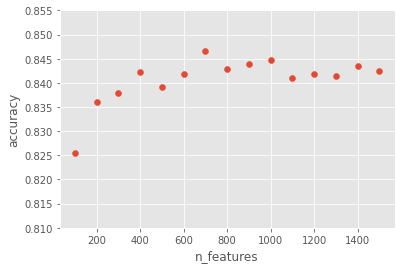

In [56]:
plt.style.use('ggplot')
plt.scatter(x = n_features, y = accuracy)
plt.ylabel('accuracy')
plt.xlabel('n_features')
plt.yticks(np.arange(0.81, 0.86,0.005))
plt.show()

### С ростом  n_features растет качество, однако оно выходит на плато, начиная с n_features = 400.

#### 3. Logreg VS SVM

In [21]:
n_feat = np.array(range(1000, 1600, 100))
acc_svm = np.zeros(len(n_feat))

for j, i in enumerate(n_feat):
  
    RFFPipe = RFFPipeline(n_features=i, classifier='SVM')
    RFFPipe.fit(x_sub_n, y_sub_n)
    preds = RFFPipe.predict(x_test)
    acc_svm[j] = accuracy_score(y_test, preds)

In [64]:
print('Accuracy LogReg with different n_features: {}'.format(accuracy[-6:]))
print('Accuracy SVM with different n_features: {}'.format(acc_svm))

Accuracy LogReg with different n_features: [0.8447 0.841  0.8419 0.8415 0.8435 0.8424]
Accuracy SVM with different n_features: [0.8317, 0.83, 0.8292, 0.8303, 0.8297, 0.8284]


### Решила сравнить модели с разным числом n_features для достоверности результата. Вывод: обе модели показывают достойное качество, однако accuracy больше в случае использования логистической регрессии + она менее времязатратная.

### Бонус

__Задание 4. (Максимум 2 балла)__

Как вы, должно быть, помните с курса МО-1, многие алгоритмы машинного обучения работают лучше, если признаки данных некоррелированы. Оказывается, что для RFF существует модификация, позволяющая получать ортогональные случайные признаки (Orthogonal Random Features, ORF). Об этом методе можно прочитать в [статье](https://proceedings.neurips.cc/paper/2016/file/53adaf494dc89ef7196d73636eb2451b-Paper.pdf). Реализуйте класс для вычисления ORF по аналогии с основным заданием. Обратите внимание, что ваш класс должен уметь работать со случаем n_features > new_dim (в статье есть замечание на этот счет). Проведите эксперименты, сравнивающие RFF и ORF, сделайте выводы.

In [80]:
import scipy
import scipy.linalg

In [210]:
# Your code here: (￣▽￣)/♫•*¨*•.¸¸♪


from sklearn.base import BaseEstimator, TransformerMixin


class RFFPipeline_ORF(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg'):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        
        Feel free to edit this template for your preferences.    
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier = classifier
        
    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪

        # 1-st step. PCA 
        
        if self.use_PCA==True:
            self.sc = StandardScaler()
            X_std = self.sc.fit_transform(X)
            self.pca = PCA(n_components=self.new_dim)
            X_pca = self.pca.fit_transform(X_std)
            self.X_pca = X_pca
        else:
            self.X_pca = X

        # 2-nd step. sigma

        var_hat_all = np.zeros(10**6)
        for par in range(10**6):
            i, j = np.random.randint(low=0, high=self.X_pca.shape[0], size=2)

            while i-j == 0:
              i, j = np.random.randint(low=0, high=self.X_pca.shape[0], size=2)
  

            res = np.sum((self.X_pca[i,:] - self.X_pca[j,:]) ** 2)
            var_hat_all[par] = res
            
        est_med = np.median(var_hat_all)
        self.est_med = est_med


        # 3-d step. generating b, W
        
        # ******** W *********

        if self.n_features == self.X_pca.shape[1]:

          G = np.zeros((self.X_pca.shape[1], self.X_pca.shape[1]))
          G[:,:] = np.random.normal(loc=0, scale=1, size=(self.X_pca.shape[1], self.X_pca.shape[1]))
          self.G = G

          Q = scipy.linalg.qr(G)[0]
          self.Q = Q

          S = np.zeros((self.X_pca.shape[1], self.X_pca.shape[1]))
          diagonal = [np.random.chisquare(df=self.X_pca.shape[1]) for i in range(self.X_pca.shape[1])] 
          np.fill_diagonal(S, diagonal)
          self.S = S

          W = np.sqrt(1/self.est_med) * self.S.dot(self.Q) 

        if self.n_features < self.X_pca.shape[1]:

          G = np.zeros((self.X_pca.shape[1], self.X_pca.shape[1]))
          G[:,:] = np.random.normal(loc=0, scale=1, size=(self.X_pca.shape[1], self.X_pca.shape[1]))
          self.G = G

          Q = scipy.linalg.qr(G)[0]
          self.Q = Q

          S = np.zeros((self.X_pca.shape[1], self.X_pca.shape[1]))
          diagonal = [np.random.chisquare(df=self.X_pca.shape[1]) for i in range(self.X_pca.shape[1])] 
          np.fill_diagonal(S, diagonal)
          self.S = S

          W = np.sqrt(1/self.est_med) * self.S.dot(self.Q) 
          W = W[:, :self.n_features]


        if self.n_features > self.X_pca.shape[1]:

          zeloe = self.n_features // self.X_pca.shape[1]
          ostatok = self.n_features % self.X_pca.shape[1]    
          
          W = [0 for i in range(zeloe + min(1,ostatok))]

          for i in range(zeloe):

            G = np.zeros((self.X_pca.shape[1], self.X_pca.shape[1]))
            G[:,:] = np.random.normal(loc=0, scale=1, size=(self.X_pca.shape[1], self.X_pca.shape[1]))
            self.G = G

            Q = scipy.linalg.qr(G)[0]
            self.Q = Q

            S = np.zeros((self.X_pca.shape[1], self.X_pca.shape[1]))
            diagonal = [np.random.chisquare(df=self.X_pca.shape[1]) for i in range(self.X_pca.shape[1])] 
            np.fill_diagonal(S, diagonal)
            self.S = S

            W[i] = np.sqrt(1/self.est_med) * self.S.dot(self.Q)  
      
          if ostatok != 0:

            G = np.zeros((self.X_pca.shape[1], self.X_pca.shape[1]))
            G[:,:] = np.random.normal(loc=0, scale=1, size=(self.X_pca.shape[1], self.X_pca.shape[1]))
            self.G = G

            Q = scipy.linalg.qr(G)[0]
            self.Q = Q

            S = np.zeros((self.X_pca.shape[1], self.X_pca.shape[1]))
            diagonal = [np.random.chisquare(df=self.X_pca.shape[1]) for i in range(self.X_pca.shape[1])] 
            np.fill_diagonal(S, diagonal)
            self.S = S

            W_small = np.sqrt(1/self.est_med) * self.S.dot(self.Q) 
            
            W[-1] = W_small[:, :ostatok]

          
          W_final = W[0]
          for j in range(1,len(W)):

            W_final = np.concatenate([W_final, W[j]], axis=1)

          W = W_final

        # ******** W *********


        b = np.random.uniform(-np.pi, np.pi, size=self.n_features)

        self.W = W
        self.b = b

        # 4-th step. cos 


        new_x = np.cos(self.X_pca.dot(self.W) + self.b)


        self.sc_new = StandardScaler()
        new_x = self.sc_new.fit_transform(new_x)

        self.new_x = new_x


        # 5-th step. Fitting logreg/SVM

        if self.classifier == 'logreg':
            clf = LogisticRegression(n_jobs=-1)
            clf.fit(self.new_x, y)
            self.clf = clf
        
        if self.classifier == 'SVM':
            clf = SVC(kernel='linear')
            clf.fit(self.new_x, y)
            self.clf = clf
        
        return self.clf


    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        if self.use_PCA==True:
            X_test_std = self.sc.transform(X)
            X_test_pca = self.pca.transform(X_test_std)
            self.X_test_pca = X_test_pca
        else:
            self.X_test_pca = X

        
        new_x_test = np.cos(self.X_test_pca.dot(self.W) + self.b)


        new_x_test = self.sc_new.transform(new_x_test)
        pred_proba = self.clf.predict_proba(new_x_test)
        
        return pred_proba

    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        
        if self.use_PCA==True:
            X_test_std = self.sc.transform(X)
            X_test_pca = self.pca.transform(X_test_std)
            self.X_test_pca = X_test_pca
        else:
            self.X_test_pca = X

        new_x_test = np.cos(self.X_test_pca.dot(self.W) + self.b)    

        new_x_test = self.sc_new.transform(new_x_test)
        pred = self.clf.predict(new_x_test)
        
        return pred

In [217]:
RFFPipe = RFFPipeline_ORF(n_features=3500, new_dim=10)


start_time = time.time()
RFFPipe.fit(x_train, y_train)
print("--- %s seconds (fit) ---" % (time.time() - start_time))


start_time = time.time()
preds = RFFPipe.predict(x_test)
print("--- %s seconds (predict) ---" % (time.time() - start_time))


print('Accuracy ORF(LogReg): {}'.format(accuracy_score(y_test, preds)))

--- 247.59407496452332 seconds (fit) ---
--- 1.9236578941345215 seconds (predict) ---
Accuracy LogReg: 0.8251


### Реализовала метод из статьи, получила хорошее, но не outstanding качество. Класс работает со всеми вариантами, в том числе для случая n_features > new_dim.

__Задание 5. (Максимум 2 балла)__

Поэкспериментируйте с функциями для вычисления новых случайных признаков. Не обязательно использовать косинус от скалярного произведения — можно брать знак от него, хэш и т.д. Придумайте побольше вариантов для генерации признаков и проверьте, не получается ли с их помощью добиваться более высокого качества. Также можете попробовать другой классификатор поверх случайных признаков, сравните результаты.

### 1. Попробуем другой способ генерации признаков 

(идея взята с просторов интернета, реализация - собственная)

In [220]:
# Your code here: (￣▽￣)/♫•*¨*•.¸¸♪
from scipy.stats import cauchy, laplace

In [239]:
from sklearn.base import BaseEstimator, TransformerMixin


class RFFPipeline_5(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=200, use_PCA=True, classifier='logreg', gamma = 0.0001):
  
        self.n_features = n_features
        self.new_dim = new_dim
        self.use_PCA = use_PCA
        self.classifier = classifier
        self.gamma = gamma
        
        
    def fit(self, X, y):
 
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪

        # PCA 
        
        if self.use_PCA==True:
            self.sc = StandardScaler()
            X_std = self.sc.fit_transform(X)
            self.pca = PCA(n_components=self.new_dim)
            X_pca = self.pca.fit_transform(X_std)
            self.X_pca = X_pca
        else:
            self.X_pca = X

        # generation of W, u
     
        d = self.X_pca.shape[1]
        
        self.W = np.sqrt(2*self.gamma)*np.random.normal(size=(self.n_features,d))
        
        self.u = 2*np.pi*np.random.rand(self.n_features)
     
        new_x = np.sqrt(2/self.n_features)*np.cos((self.X_pca.dot(self.W.T) + self.u))


        self.sc_new = StandardScaler()
        new_x = self.sc_new.fit_transform(new_x)

        self.new_x = new_x


        # Fitting logreg/SVM

        if self.classifier == 'logreg':
            clf = LogisticRegression(n_jobs=-1)
            clf.fit(self.new_x, y)
            self.clf = clf
        
        if self.classifier == 'SVM':
            clf = SVC(kernel='linear')
            clf.fit(self.new_x, y)
            self.clf = clf
        
        return self.clf


    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        if self.use_PCA==True:
            X_test_std = self.sc.transform(X)
            X_test_pca = self.pca.transform(X_test_std)
            self.X_test_pca = X_test_pca
        else:
            self.X_test_pca = X

      

        new_x_test = np.sqrt(2/self.n_features)*np.cos((self.X_test_pca.dot(self.W.T) + self.u))

        new_x_test = self.sc_new.transform(new_x_test)
        pred_proba = self.clf.predict_proba(new_x_test)
        
        return pred_proba

    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        
        if self.use_PCA==True:
            X_test_std = self.sc.transform(X)
            X_test_pca = self.pca.transform(X_test_std)
            self.X_test_pca = X_test_pca
        else:
            self.X_test_pca = X

        new_x_test = np.sqrt(2/self.n_features)*np.cos((self.X_test_pca.dot(self.W.T) + self.u)) 

        new_x_test = self.sc_new.transform(new_x_test)
        pred = self.clf.predict(new_x_test)
        
        return pred

In [245]:
RFFPipe = RFFPipeline_5()


start_time = time.time()
RFFPipe.fit(x_train, y_train)
print("--- %s seconds (fit) ---" % (time.time() - start_time))


start_time = time.time()
preds = RFFPipe.predict(x_test)
print("--- %s seconds (predict) ---" % (time.time() - start_time))


print('Accuracy LogReg: {}'.format(accuracy_score(y_test, preds)))

--- 65.34981632232666 seconds (fit) ---
--- 0.8155701160430908 seconds (predict) ---
Accuracy LogReg: 0.8707


### Wow! Accuracy = 0.8707 => качество больше, чем изначально при RFF (logreg) - 0.8671 на этом же датасете.

#### 2. Вариант с другим классификатором (SGD):

In [242]:
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.linear_model import SGDClassifier

class RFFPipeline_SGD(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='SGD'):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        
        Feel free to edit this template for your preferences.    
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier = classifier
        
    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪

        # 1-st step. PCA 
        
        if self.use_PCA==True:
            self.sc = StandardScaler()
            X_std = self.sc.fit_transform(X)
            self.pca = PCA(n_components=self.new_dim)
            X_pca = self.pca.fit_transform(X_std)
            self.X_pca = X_pca
        else:
            self.X_pca = X

        # 2-nd step. sigma

        var_hat_all = np.zeros(10**6)
        for par in range(10**6):
            i, j = np.random.randint(low=0, high=self.X_pca.shape[0], size=2)

            while i-j == 0:
              i, j = np.random.randint(low=0, high=self.X_pca.shape[0], size=2)
  

            res = np.sum((self.X_pca[i,:] - self.X_pca[j,:]) ** 2)
            var_hat_all[par] = res
            
        est_med = np.median(var_hat_all)
        self.est_med = est_med


        # 3-d step. generating b, W
        
        b = np.random.uniform(-np.pi, np.pi, size=self.n_features)
        
        W = np.zeros((self.X_pca.shape[1], self.n_features))
        W[:,:] = np.random.normal(loc=0, scale=np.sqrt(1/self.est_med), size=(self.X_pca.shape[1], self.n_features))

        self.W = W
        self.b = b

        # 4-th step. cos 


        new_x = np.cos(self.X_pca.dot(self.W) + self.b)


        self.sc_new = StandardScaler()
        new_x = self.sc_new.fit_transform(new_x)

        self.new_x = new_x


        # 5-th step. Fitting SGD


        if self.classifier == 'SGD':
            clf = SGDClassifier()
            clf.fit(self.new_x, y)
            self.clf = clf
        
        return self.clf


    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        if self.use_PCA==True:
            X_test_std = self.sc.transform(X)
            X_test_pca = self.pca.transform(X_test_std)
            self.X_test_pca = X_test_pca
        else:
            self.X_test_pca = X

        
        new_x_test = np.cos(self.X_test_pca.dot(self.W) + self.b)


        new_x_test = self.sc_new.transform(new_x_test)
        pred_proba = self.clf.predict_proba(new_x_test)
        
        return pred_proba

    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        
        if self.use_PCA==True:
            X_test_std = self.sc.transform(X)
            X_test_pca = self.pca.transform(X_test_std)
            self.X_test_pca = X_test_pca
        else:
            self.X_test_pca = X

        new_x_test = np.cos(self.X_test_pca.dot(self.W) + self.b)    

        new_x_test = self.sc_new.transform(new_x_test)
        pred = self.clf.predict(new_x_test)
        
        return pred

In [243]:
RFFPipe = RFFPipeline_SGD()


start_time = time.time()
RFFPipe.fit(x_train, y_train)
print("--- %s seconds (fit) ---" % (time.time() - start_time))


start_time = time.time()
preds = RFFPipe.predict(x_test)
print("--- %s seconds (predict) ---" % (time.time() - start_time))


print('Accuracy SGD: {}'.format(accuracy_score(y_test, preds)))

--- 297.9759159088135 seconds (fit) ---
--- 0.6072912216186523 seconds (predict) ---
Accuracy LogReg: 0.8511


#### Качество ниже, чем в RFF (logreg), но выше, чем в RFF (SVM).